In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [481]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.base import BaseEstimator,RegressorMixin,TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler,QuantileTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,NMF
from sklearn.model_selection import StratifiedKFold,KFold

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgb

from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score,make_scorer

from pf_models import *

In [25]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer
#transformer = FunctionTransformer(np.log1p, validate=True)


In [438]:
def add_col(df,col,target,funcs):
    part_df = df.groupby(col)[target].agg(funcs)#.sort_values(by='count')
    part_df.columns = [col+'_'+func for func in funcs]
    return df.merge(part_df, how='left', on=col)


In [201]:
with open('dump_data/train_proc','rb') as f:
    df_train = pickle.load(f)
    
with open('dump_data/test_proc','rb') as f:
    df_test = pickle.load(f)

In [566]:
tdf = pd.concat([df_train,df_test])

target = ['AdoptionSpeed']
text_features = ['Description', 'metadata_annots_top_desc', 'sentiment_entities']

factor_features = ['main_breed_BreedName', 'second_breed_BreedName']

categorical_features = [#TODO CHECK if it matters 
                        #'Breed1','Breed2',
                        #'main_breed_Type','second_breed_Type',
                        #'State',
                        #'Sterilized',
                        #'RescuerID_COUNT',
                        'Type','Gender',
                        #'Dewormed','Vaccinated'
                        ]

to_drop_features = ['PetID', 'Name', 'RescuerID',
                   #'Color1','Color2','Color3',
                   #'State',
                   #'Breed1','Breed2',
                   #'main_breed_Type','second_breed_Type',
                   #'main_breed_BreedName', 'second_breed_BreedName',
                   #'MaturitySize','FurLength'
                   ]

for c in text_features:
    tdf.loc[:, c].fillna('<MISSING>',inplace=True)

In [567]:
tdf = tdf[['Type','Breed1','Breed2','AdoptionSpeed','Description','Age','State','Type','Gender','RescuerID']]

In [ ]:
#rescuer_count = tdf.groupby(['RescuerID'])['PetID'].count().reset_index()
#rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']
#tdf = tdf.merge(rescuer_count, how='left', on='RescuerID')
#transformer = FunctionTransformer(np.log1p, validate=True)


In [568]:
tdf = add_col(tdf,'Breed1','AdoptionSpeed',['mean'])
tdf = add_col(tdf,'Breed2','AdoptionSpeed',['mean'])
tdf = add_col(tdf,'State','AdoptionSpeed',['mean'])
tdf = add_col(tdf,'RescuerID','Age',['count'])


In [569]:
tdf.head()

,Type,Breed1,Breed2,AdoptionSpeed,Description,Age,State,Type,Gender,RescuerID,Breed1_mean,Breed2_mean,State_mean,RescuerID_count
0,2,299,0,2.0,Nibble is a 3+ month old ball of cuteness. He ...,3,41326,2,1,8480853f516546f6cf33aa88cd76c379,2.421053,2.538469,2.452031,8
1,2,265,0,0.0,I just found it alone yesterday near my apartm...,1,41401,2,1,3082c7125d8fb66f7dd4bff4192c8b14,2.339428,2.538469,2.540182,1
2,1,307,0,3.0,Their pregnant mother was dumped by her irresp...,1,41326,1,1,fa90fa5b1ee11c86938398b60abc32cb,2.746077,2.538469,2.452031,459
3,1,307,0,2.0,"Good guard dog, very alert, active, obedience ...",4,41401,1,2,9238e4f44c71a75282e62f7136c6b240,2.746077,2.538469,2.540182,50
4,1,307,0,2.0,This handsome yet cute boy is up for adoption....,1,41326,1,1,95481e953f8aed9ec3d16fc4509537e8,2.746077,2.538469,2.452031,134


In [582]:
kbd = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
qt = QuantileTransformer(n_quantiles=50,output_distribution='normal')

bins_features = ['Breed1_mean','Breed2_mean','RescuerID_count']
bins_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('biner', kbd)
])

categorical_features = ['Type','Gender',
                        #'Dewormed','Vaccinated'
                        ]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


numeric_features = ['Age','State_mean']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('normal', qt),
    ('scaler', MinMaxScaler())
    ])

In [583]:
preprocessor = ColumnTransformer(
    transformers=[
            ('bins',bins_transformer,bins_features),
            ('cat',categorical_transformer,categorical_features),
            ('nums',numeric_transformer,numeric_features)
    ],
    remainder='drop')

clf = Pipeline(steps=[('preprocessor', preprocessor),('sca',MinMaxScaler())])

In [545]:
#clf.named_steps['preprocessor'].named_transformers_['bins'].named_steps['biner'].bin_edges_

In [584]:
mask = tdf.AdoptionSpeed.isnull()
X_test = tdf[mask].drop(columns=['AdoptionSpeed'])
X_train = tdf[~mask]
X_test.shape,X_train.shape

((3948, 13), (14993, 14))

In [585]:
model = LGBMClassifier(max_depth=100,n_estimators=100)
#model = RandomForestClassifier()

In [586]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits,shuffle=True)
cv2 = KFold(n_splits=n_splits,shuffle=True)

In [587]:
X = clf.fit_transform(X_train)
y = X_train.AdoptionSpeed
#y = OneHotEncoder().fit_transform(X_train[['AdoptionSpeed']])

In [588]:
X[0]

array([0.22222222, 0.88888889, 0.42857143, 0.        , 1.        ,
       0.        , 1.        , 1.        , 0.        , 0.        ,
       0.49014389, 0.45677204])

(0.35074183711951845, 0.014205973560007298, 0.04050264911843546)

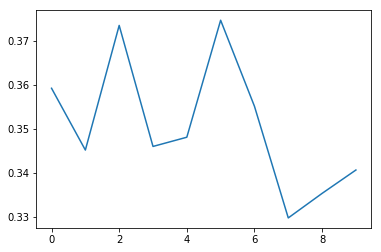

In [590]:
scorer = make_scorer(cohen_kappa_score,weights='quadratic')
scores = cross_val_score(model,X,y,cv=cv,scoring=scorer)
plt.plot(scores)
scores.mean(),scores.std(),scores.std()/scores.mean()


In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value=-9999)),
    #('scaler', StandardScaler())
    ])



categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

bins_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('label_enc', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'))
])

text_transformer = Pipeline(steps=[
    ('tf-idf', TfidfVectorizer(stop_words = 'english')),
    ('svd',TruncatedSVD(n_components=5))
])

text_transformer_2 = Pipeline(steps=[
    ('tf-idf', TfidfVectorizer(stop_words = 'english')),
    ('nmf',NMF(n_components=5))
])


preprocessor = ColumnTransformer(
    transformers=[
        #('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('fact', factor_transformer, factor_features),
        *[('txt_1_'+f, text_transformer,f) for f in text_features],
        *[('txt_2_'+f, text_transformer_2,f) for f in text_features]
    ],
    remainder='passthrough')

clf = Pipeline(steps=[('preprocessor', preprocessor),('scaler',StandardScaler())])